# Necessary Functions

In [22]:
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
import numpy as np
import pandas as pd
import shutil
import time
import cv2 as cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from IPython.core.display import display, HTML
# stop annoying tensorflow warning messages
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

# Functions

In [23]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i]/255
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=12)
        plt.axis('off')
    plt.show()

In [24]:
def show_images(tdir):
    classlist=os.listdir(tdir)
    length=len(classlist)
    columns=5
    rows=int(np.ceil(length/columns))    
    plt.figure(figsize=(20, rows * 4))
    for i, klass in enumerate(classlist):    
        classpath=os.path.join(tdir, klass)
        imgpath=os.path.join(classpath, '1.jpg')
        img=plt.imread(imgpath)
        plt.subplot(rows, columns, i+1)
        plt.axis('off')
        plt.title(klass, color='blue', fontsize=12)
        plt.imshow(img)

In [25]:
# for RGB foreground and background
def print_in_color(txt_msg,fore_tupple,back_tupple,):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple 
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

In [26]:
# Define a subclass of Keras callbacks that will control the learning rate and print training data in spreadsheet format. The callback also includes a feature to periodically ask if you want to train for N more epochs or halt
class LRA(keras.callbacks.Callback):
    def __init__(self,model, base_model, patience,stop_patience, threshold, factor, dwell, batches, initial_epoch,epochs, ask_epoch):
        super(LRA, self).__init__()
        self.model=model
        self.base_model=base_model
        self.patience=patience # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience=stop_patience # specifies how many times to adjust lr without improvement to stop training
        self.threshold=threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor=factor # factor by which to reduce the learning rate
        self.dwell=dwell
        self.batches=batches # number of training batch to runn per epoch
        self.initial_epoch=initial_epoch
        self.epochs=epochs
        self.ask_epoch=ask_epoch
        self.ask_epoch_initial=ask_epoch # save this value to restore if restarting training
        # callback variables 
        self.count=0 # how many times lr has been reduced without improvement
        self.stop_count=0        
        self.best_epoch=1   # epoch with the lowest loss        
        self.initial_lr=float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initiallearning rate and save it         
        self.highest_tracc=0.0 # set highest training accuracy to 0 initially
        self.lowest_vloss=np.inf # set lowest validation loss to infinity initially
        self.best_weights=self.model.get_weights() # set best weights to model's initial weights
        self.initial_weights=self.model.get_weights()   # save initial weights if they have to get restored 
        
    def on_train_begin(self, logs=None):        
        if self.base_model != None:
            status=base_model.trainable
            if status:
                msg=' initializing callback starting train with base_model trainable'
            else:
                msg='initializing callback starting training with base_model not trainable'
        else:
            msg='initialing callback and starting training'                        
        print_in_color (msg, (244, 252, 3), (55,65,80)) 
        msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy',
                                                                                              'V_loss','V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
        print_in_color(msg, (244,252,3), (55,65,80)) 
        self.start_time= time.time()
        
    def on_train_end(self, logs=None):
        stop_time=time.time()
        tr_duration= stop_time- self.start_time            
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))

        self.model.set_weights(self.best_weights) # set the weights of the model to the best weights
        msg=f'Training is completed - model is set with weights from epoch {self.best_epoch} '
        print_in_color(msg, (0,255,0), (55,65,80))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print_in_color(msg, (0,255,0), (55,65,80))   
        
    def on_train_batch_end(self, batch, logs=None):
        acc=logs.get('accuracy')* 100  # get training accuracy 
        loss=logs.get('loss')
        msg='{0:20s}processing batch {1:4s} of {2:5s} accuracy= {3:8.3f}  loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end='') # prints over on the same line to show running batch count        
        
    def on_epoch_begin(self,epoch, logs=None):
        self.now= time.time()
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        later=time.time()
        duration=later-self.now 
        lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        current_lr=lr
        v_loss=logs.get('val_loss')  # get the validation loss for this epoch
        acc=logs.get('accuracy')  # get training accuracy 
        v_acc=logs.get('val_accuracy')
        loss=logs.get('loss')        
        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            monitor='accuracy'
            if epoch ==0:
                pimprov=0.0
            else:
                pimprov= (acc-self.highest_tracc )*100/self.highest_tracc
            if acc>self.highest_tracc: # training accuracy improved in the epoch                
                self.highest_tracc=acc # set new highest training accuracy
                self.best_weights=self.model.get_weights() # traing accuracy improved so save the weights
                self.count=0 # set count to 0 since training accuracy improved
                self.stop_count=0 # set stop counter to 0
                if v_loss<self.lowest_vloss:
                    self.lowest_vloss=v_loss
                color= (0,255,0)
                self.best_epoch=epoch + 1  # set the value of best epoch for this epoch              
            else: 
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count>=self.patience -1: # lr should be adjusted
                    color=(245, 170, 66)
                    lr= lr* self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    self.count=0 # reset the count to 0
                    self.stop_count=self.stop_count + 1 # count the number of consecutive lr adjustments
                    self.count=0 # reset counter
                    if self.dwell:
                        self.model.set_weights(self.best_weights) # return to better point in N space                        
                    else:
                        if v_loss<self.lowest_vloss:
                            self.lowest_vloss=v_loss                                    
                else:
                    self.count=self.count +1 # increment patience counter                    
        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor='val_loss'
            if epoch ==0:
                pimprov=0.0
            else:
                pimprov= (self.lowest_vloss- v_loss )*100/self.lowest_vloss
            if v_loss< self.lowest_vloss: # check if the validation loss improved 
                self.lowest_vloss=v_loss # replace lowest validation loss with new validation loss                
                self.best_weights=self.model.get_weights() # validation loss improved so save the weights
                self.count=0 # reset count since validation loss improved  
                self.stop_count=0  
                color=(0,255,0)                
                self.best_epoch=epoch + 1 # set the value of the best epoch to this epoch
            else: # validation loss did not improve
                if self.count>=self.patience-1: # need to adjust lr
                    color=(245, 170, 66)
                    lr=lr * self.factor # adjust the learning rate                    
                    self.stop_count=self.stop_count + 1 # increment stop counter because lr was adjusted 
                    self.count=0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    if self.dwell:
                        self.model.set_weights(self.best_weights) # return to better point in N space
                else: 
                    self.count =self.count +1 # increment the patience counter                    
                if acc>self.highest_tracc:
                    self.highest_tracc= acc
        msg=f'{str(epoch+1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc*100:^9.3f}{v_loss:^9.5f}{v_acc*100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
        print_in_color (msg,color, (55,65,80))
        if self.stop_count> self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg=f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print_in_color(msg, (0,255,255), (55,65,80))
            self.model.stop_training = True # stop training
        else: 
            if self.ask_epoch !=None:
                if epoch + 1 >= self.ask_epoch:
                    if base_model.trainable:
                        msg='enter H to halt  or an integer for number of epochs to run then ask again'
                    else:
                        msg='enter H to halt ,F to fine tune model, or an integer for number of epochs to run then ask again'
                    print_in_color(msg, (0,255,255), (55,65,80))
                    ans=input('')
                    if ans=='H' or ans=='h':
                        msg=f'training has been halted at epoch {epoch + 1} due to user input'
                        print_in_color(msg, (0,255,255), (55,65,80))
                        self.model.stop_training = True # stop training
                    elif ans == 'F' or ans=='f':
                        if base_model.trainable:
                            msg='base_model is already set as trainable'
                        else:
                            msg='setting base_model as trainable for fine tuning of model'
                            self.base_model.trainable=True
                        print_in_color(msg, (0, 255,255), (55,65,80))
                        msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:^8s}'.format('Epoch', 'Loss', 'Accuracy',
                                                                                              'V_loss','V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
                        print_in_color(msg, (244,252,3), (55,65,80))                         
                        self.count=0
                        self.stop_count=0                        
                        self.ask_epoch = epoch + 1 + self.ask_epoch_initial 
                        
                    else:
                        ans=int(ans)
                        self.ask_epoch +=ans
                        msg=f' training will continue until epoch ' + str(self.ask_epoch)                         
                        print_in_color(msg, (0, 255,255), (55,65,80))
                        msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy',
                                                                                              'V_loss','V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
                        print_in_color(msg, (244,252,3), (55,65,80)) 

In [27]:
# Define a function to plot the training data
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()

In [28]:
# define a function to create confusion matrix and classification report
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames 
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
  # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names     
    errors=0      
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)         
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)            
            errors=errors + 1
        y_pred.append(pred_index)    
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code           
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):                
                split1=os.path.split(error_list[i])                
                split2=os.path.split(split1[0])                
                fname=split2[1] + '/' + split1[1]
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])               
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():        
            count=error_indices.count(key) 
            if count!=0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class 
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    y_true= np.array(labels)        
    y_pred=np.array(y_pred)
    if len(classes)<= 30:
        # create a confusion matrix 
        cm = confusion_matrix(y_true, y_pred )        
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)


In [29]:
# define a function to save the model and the associated class_dict.csv file
def saver(save_path, model, model_name, subject, accuracy,img_size, scalar, generator):
    # first save the model
    save_id=str (model_name +  '-' + subject +'-'+ str(acc)[:str(acc).rfind('.')+3] + '.keras')
    model_save_loc=os.path.join(save_path, save_id)
    model.save(model_save_loc)
    print_in_color ('model was saved as ' + model_save_loc, (0,255,0),(55,65,80)) 
    # now create the class_df and convert to csv file    
    class_dict=generator.class_indices 
    height=[]
    width=[]
    scale=[]
    for i in range(len(class_dict)):
        height.append(img_size[0])
        width.append(img_size[1])
        scale.append(scalar)
    Index_series=pd.Series(list(class_dict.values()), name='class_index')
    Class_series=pd.Series(list(class_dict.keys()), name='class') 
    Height_series=pd.Series(height, name='height')
    Width_series=pd.Series(width, name='width')
    Scale_series=pd.Series(scale, name='scale by')
    class_df=pd.concat([Index_series, Class_series, Height_series, Width_series, Scale_series], axis=1)    
    csv_name='class_dict.csv'
    csv_save_loc=os.path.join(save_path, csv_name)
    class_df.to_csv(csv_save_loc, index=False) 
    print_in_color ('class csv file was saved as ' + csv_save_loc, (0,255,0),(55,65,80)) 
    return model_save_loc, csv_save_loc

In [30]:
def predictor(sdir, csv_path, model_path, crop_image=False):    
    import os
    import cv2
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from tensorflow.keras.models import load_model

    # === Load CSV Info ===
    class_df = pd.read_csv(csv_path)    
    print("📋 Class Mapping from CSV:", class_df['class'].tolist())
    img_height = int(class_df['height'].iloc[0])
    img_width = int(class_df['width'].iloc[0])
    img_size = (img_width, img_height)
    scale = class_df['scale by'].iloc[0] 

    try: 
        s = int(scale)
        s2 = 1
        s1 = 0
    except:
        split = scale.split('-')
        s1 = float(split[1])
        s2 = float(split[0].split('*')[1]) 
        print(f"📏 Scaling used → s1: {s1}, s2: {s2}")

    # === Handle file or directory input ===
    if os.path.isdir(sdir):
        path_list = [os.path.join(sdir, f) for f in os.listdir(sdir)]
    else:
        path_list = [sdir]

    print('📦 Model is being loaded - this will take about 10 seconds')
    model = load_model(model_path)

    image_count = len(path_list)    
    index_list = [] 
    prob_list = []
    cropped_image_list = []
    good_image_count = 0

    for path in path_list:
        img = cv2.imread(path)
        if img is None:
            print(f"❌ Failed to read image: {path}")
            continue

        if crop_image:
            status, img = crop(img)  # Define this only if cropping needed
        else:
            status = True

        if status:
            good_image_count += 1
            img = cv2.resize(img, img_size)

            # === CLAHE ===
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
            l, a, b = cv2.split(lab)
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            cl = clahe.apply(l)
            merged = cv2.merge((cl, a, b))
            img = cv2.cvtColor(merged, cv2.COLOR_LAB2RGB)

            # === Normalize & Scale ===
            cropped_image_list.append(img)
            img = img.astype(np.float32) / 255.0
            img = img * s2 - s1
            img = np.expand_dims(img, axis=0)

            # === Predict ===
            p = np.squeeze(model.predict(img))
            
            print(f"\n🖼️ Image: {os.path.basename(path)}")
            print(f"🔢 Softmax Output: {np.round(p, 3)}")
            print(f"🎯 Predicted: {class_df['class'].iloc[np.argmax(p)]}, Confidence: {np.max(p) * 100:.2f}%")

            index = np.argmax(p)
            prob = p[index]
            index_list.append(index)
            prob_list.append(prob)

    if good_image_count == 0:
        print("⚠️ No valid images found.")
        return None, None

    # === Show all images with prediction
    for i in range(good_image_count):
        pred_class = class_df['class'].iloc[index_list[i]]
        confidence = prob_list[i] * 100
        img = cropped_image_list[i]

        plt.figure(figsize=(3, 3))
        plt.title(f'{pred_class} ({confidence:.2f}%)', color='green')
        plt.axis('off')
        plt.imshow(img)
        plt.show()

    # === Single image case
    if good_image_count == 1:
        return class_df['class'].iloc[index_list[0]], prob_list[0]

    # === Voting strategy
    from collections import Counter
    voted_idx = Counter(index_list).most_common(1)[0][0]
    final_class = class_df['class'].iloc[voted_idx]
    final_confidence = np.mean([prob_list[i] for i in range(len(index_list)) if index_list[i] == voted_idx])

    return final_class, final_confidence



In [31]:
# define a function tha takes in a dataframe df, and integer max_size and a string column and returns a dataframe where the number of samples for any class specified by column is limited to max samples
def trim (df, max_size, min_size, column):
    df=df.copy()
    sample_list=[] 
    groups=df.groupby(column)
    for label in df[column].unique():        
        group=groups.get_group(label)
        sample_count=len(group)         
        if sample_count> max_size :
            samples=group.sample(max_size, replace=False, weights=None, random_state=123, axis=0).reset_index(drop=True)
            sample_list.append(samples)
        elif sample_count>= min_size:
            sample_list.append(group)
    df=pd.concat(sample_list, axis=0).reset_index(drop=True)
    balance=list(df[column].value_counts())
    print (balance)
    return df

(224, 224, 3)


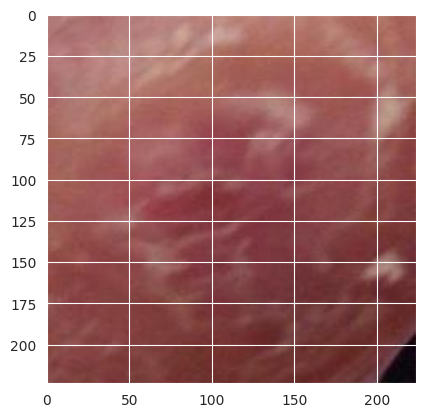

In [32]:
fpath = '/kaggle/input/graded-dataset/graded_dataset/train/Grade_0/301000.jpg'
img=plt.imread(fpath)
print (img.shape)

imshow(img)

In [33]:
# define function to preprocess the dataframe
def preprocess (sdir, trsplit, vsplit):
    filepaths=[]
    labels=[]    
    classlist=os.listdir(sdir)
    for klass in classlist:
        classpath=os.path.join(sdir,klass)
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)
    Fseries=pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels')
    df=pd.concat([Fseries, Lseries], axis=1)       
    # split df into train_df and test_df 
    dsplit=vsplit/(1-trsplit)
    strat=df['labels']    
    train_df, dummy_df=train_test_split(df, train_size=trsplit, shuffle=True, random_state=123, stratify=strat)
    strat=dummy_df['labels']
    valid_df, test_df=train_test_split(dummy_df, train_size=dsplit, shuffle=True, random_state=123, stratify=strat)
    print('train_df length: ', len(train_df), '  test_df length: ',len(test_df), '  valid_df length: ', len(valid_df))
    print(train_df['labels'].value_counts())
    return train_df, test_df, valid_df

# Patches Input

In [34]:
sdir = '/kaggle/input/graded-dataset/graded_dataset/train'
train_df, test_df, valid_df= preprocess(sdir, .8,.1)

train_df length:  13738   test_df length:  1718   valid_df length:  1717
labels
Grade_5    3356
Grade_3    2502
Grade_0    2450
Grade_1    2030
Grade_4    1795
Grade_2    1605
Name: count, dtype: int64


In [35]:
def trim(df, max_samples, min_samples, column):
    groups = df.groupby(column)
    result_df = pd.DataFrame()
    for _, group in groups:
        if len(group) > max_samples:
            result_df = pd.concat([result_df, group.sample(max_samples)])
        elif len(group) < min_samples:
            result_df = pd.concat([result_df, group.sample(min_samples, replace=True)])
        else:
            result_df = pd.concat([result_df, group])
    return result_df.reset_index(drop=True)


In [36]:
# function to balance normal and abnormal
def balance(train_df,max_samples, min_samples, column, working_dir, image_size):
    train_df=train_df.copy()
    train_df=trim (train_df, max_samples, min_samples, column)    
    # make directories to store augmented images
    aug_dir=os.path.join(working_dir, 'aug')
    if os.path.isdir(aug_dir):
        shutil.rmtree(aug_dir)
    os.mkdir(aug_dir)
    for label in train_df['labels'].unique():    
        dir_path=os.path.join(aug_dir,label)    
        os.mkdir(dir_path)
    # create and store the augmented images  
    total=0
    gen=ImageDataGenerator(horizontal_flip=True,  rotation_range=20, width_shift_range=.2,
                                  height_shift_range=.2, zoom_range=.2)
    groups=train_df.groupby('labels') # group by class
    for label in train_df['labels'].unique():  # for every class               
        group=groups.get_group(label)  # a dataframe holding only rows with the specified label 
        sample_count=len(group)   # determine how many samples there are in this class  
        if sample_count< max_samples: # if the class has less than target number of images
            aug_img_count=0
            delta=max_samples-sample_count  # number of augmented images to create
            target_dir=os.path.join(aug_dir, label)  # define where to write the images    
            aug_gen=gen.flow_from_dataframe( group,  x_col='filepaths', y_col=None, target_size=image_size,
                                            class_mode=None, batch_size=1, shuffle=False, 
                                            save_to_dir=target_dir, save_prefix='aug-', color_mode='rgb',
                                            save_format='jpg')
            while aug_img_count<delta:
                images=next(aug_gen)            
                aug_img_count += len(images)
            total +=aug_img_count
    print('Total Augmented images created= ', total)
    # create aug_df and merge with train_df to create composite training set ndf
    if total>0:
        aug_fpaths=[]
        aug_labels=[]
        classlist=os.listdir(aug_dir)
        for klass in classlist:
            classpath=os.path.join(aug_dir, klass)     
            flist=os.listdir(classpath)    
            for f in flist:        
                fpath=os.path.join(classpath,f)         
                aug_fpaths.append(fpath)
                aug_labels.append(klass)
        Fseries=pd.Series(aug_fpaths, name='filepaths')
        Lseries=pd.Series(aug_labels, name='labels')
        aug_df=pd.concat([Fseries, Lseries], axis=1)
        ndf=pd.concat([train_df,aug_df], axis=0).reset_index(drop=True)
    else:
        ndf=train_df
    print (list(ndf['labels'].value_counts()) )
    return ndf 

## After Balancing

In [37]:
max_samples= 410
min_samples=0
column='labels'
working_dir = r'./'
img_size=(224,224)
ndf=balance(train_df,max_samples, min_samples, column, working_dir, img_size)

Total Augmented images created=  0
[410, 410, 410, 410, 410, 410]


# Generate Test, Train, and Validation

In [38]:
channels=3
batch_size=30
img_shape=(img_size[0], img_size[1], channels)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)
def scalar(img):    
    return img  # EfficientNet expects pixelsin range 0 to 255 so no scaling is required
trgen=ImageDataGenerator(preprocessing_function=scalar, horizontal_flip=True)
tvgen=ImageDataGenerator(preprocessing_function=scalar)
train_gen=trgen.flow_from_dataframe( ndf, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
test_gen=tvgen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)

valid_gen=tvgen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
classes=list(train_gen.class_indices.keys())
class_count=len(classes)
train_steps=int(np.ceil(len(train_gen.labels)/batch_size))

test batch size:  2   test steps:  859
Found 2460 validated image filenames belonging to 6 classes.
Found 1718 validated image filenames belonging to 6 classes.
Found 1717 validated image filenames belonging to 6 classes.


## Train Image Samples

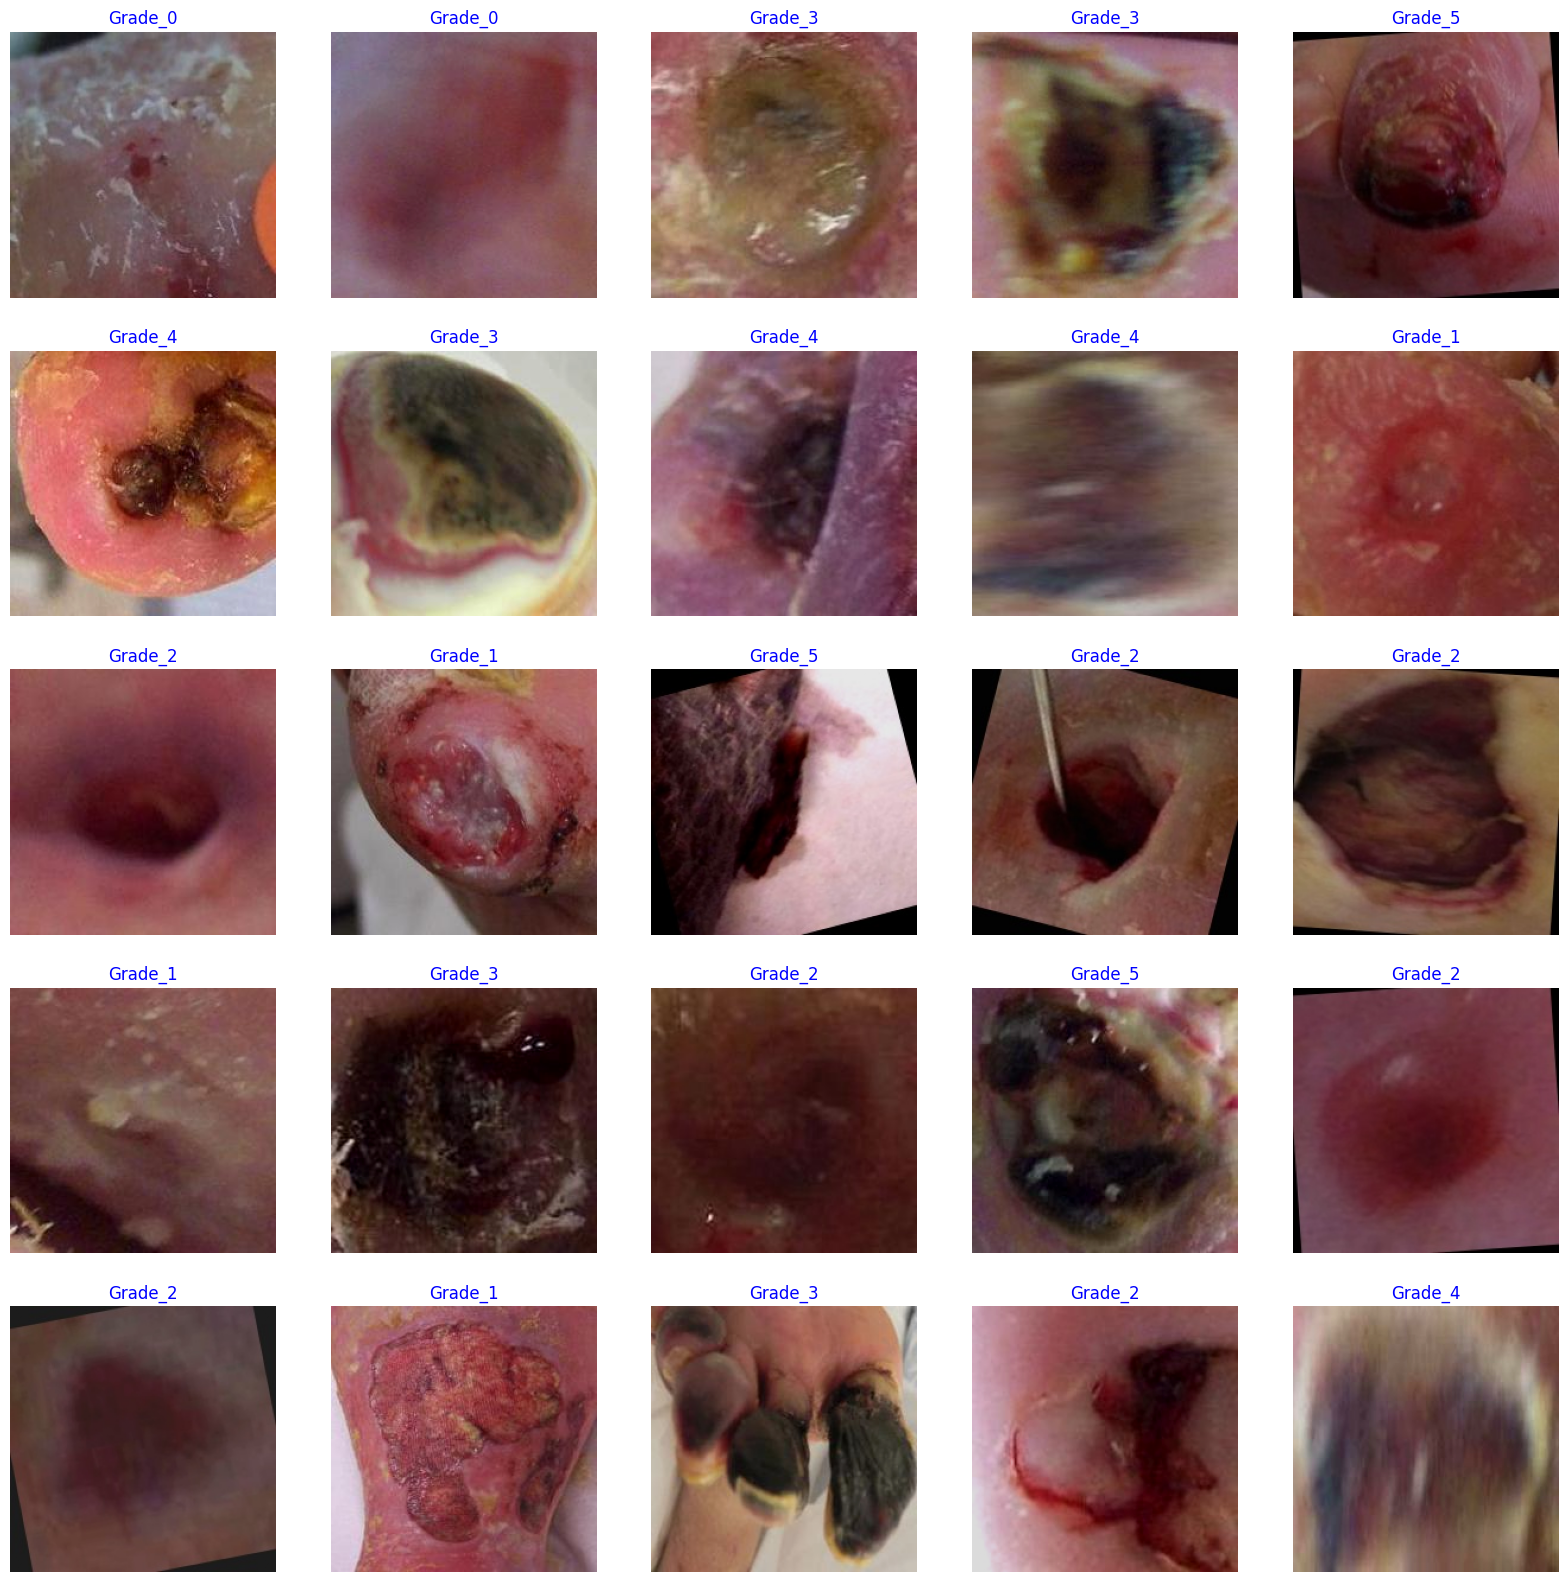

In [39]:
show_image_samples(train_gen)

# Model

## LRA updated

In [42]:
import tensorflow as tf
from tensorflow.keras.callbacks import Callback
import numpy as np

class LRA(Callback):
    def __init__(self, patience, stop_patience, factor, dwell):
        super(LRA, self).__init__()
        self.patience = patience
        self.stop_patience = stop_patience
        self.factor = factor
        self.dwell = dwell
        
        self.best_weights = None
        self.best = np.Inf
        self.wait = 0
        self.lr_reduced = 0

    def on_train_begin(self, logs=None):
        self.best = np.Inf
        self.wait = 0
        self.lr_reduced = 0

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        current = logs.get('val_loss')
        if current is None:
            return
        
        if current < self.best:
            self.best = current
            self.wait = 0
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.lr_reduced += 1
                new_lr = float(tf.keras.backend.get_value(self.model.optimizer.lr) * self.factor)
                tf.keras.backend.set_value(self.model.optimizer.lr, new_lr)
                print(f'\nEpoch {epoch+1}: reducing learning rate to {new_lr:.6f}')
                self.wait = 0
                
                if self.dwell:
                    self.model.set_weights(self.best_weights)
        
        if self.lr_reduced >= self.stop_patience:
            self.model.stop_training = True
            print(f'\nEpoch {epoch+1}: early stopping')



In [41]:
pip install -U keras-cv


Note: you may need to restart the kernel to use updated packages.


# Inception V3

In [76]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import InceptionV3

# Model definition
model_name = 'InceptionV3'
base_model = InceptionV3(
    include_top=False, 
    weights="imagenet",
    input_shape=img_shape,
    pooling=None
) 

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = Dropout(0.3)(x)
output = Dense(class_count, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Training setup
epochs = 100
patience = 10
stop_patience = 20
factor = 0.5
dwell = True

# Create and use the LRA callback
callbacks = [
    LRA(patience=patience, stop_patience=stop_patience, factor=factor, dwell=dwell),
    tf.keras.callbacks.EarlyStopping(patience=stop_patience, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=factor, patience=patience)
]

# Start training
history = model.fit(
    train_gen,
    epochs=epochs,
    validation_data=valid_gen,
    callbacks=callbacks,
    verbose=1
)

# Fine-tuning
print("Fine-tuning the model...")
for layer in base_model.layers[-30:]:  # Adjust the number of layers to fine-tune as needed
    layer.trainable = True

model.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_fine = model.fit(
    train_gen,
    epochs=50,
    validation_data=valid_gen,
    callbacks=callbacks,
    verbose=1
) 


Epoch 1/100
 2/82 ━━━━━━━━━━━━━━━━━━━━ 7s 94ms/step - accuracy: 0.1583 - loss: 23.6540  

W0000 00:00:1747546035.854715     130 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.2250 - loss: 14.6197

W0000 00:00:1747546063.625534     128 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1747546072.267816     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


82/82 ━━━━━━━━━━━━━━━━━━━━ 53s 454ms/step - accuracy: 0.2254 - loss: 14.5742 - val_accuracy: 0.3920 - val_loss: 3.3970 - learning_rate: 1.0000e-04
Epoch 2/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 16s 190ms/step - accuracy: 0.2885 - loss: 5.4036 - val_accuracy: 0.3826 - val_loss: 2.7757 - learning_rate: 1.0000e-04
Epoch 3/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 16s 189ms/step - accuracy: 0.3134 - loss: 3.9857 - val_accuracy: 0.3762 - val_loss: 2.5907 - learning_rate: 1.0000e-04
Epoch 4/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 16s 180ms/step - accuracy: 0.2926 - loss: 3.3078 - val_accuracy: 0.4089 - val_loss: 2.5113 - learning_rate: 1.0000e-04
Epoch 5/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 15s 178ms/step - accuracy: 0.3166 - loss: 3.0975 - val_accuracy: 0.3891 - val_loss: 2.5164 - learning_rate: 1.0000e-04
Epoch 6/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 17s 195ms/step - accuracy: 0.3437 - loss: 2.8943 - val_accuracy: 0.4089 - val_loss: 2.4656 - learning_rate: 1.0000e-04
Epoch 7/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 16s 191ms/step - accurac

W0000 00:00:1747547700.556786     128 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.2396 - loss: 2.1906

W0000 00:00:1747547713.968636     130 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1747547722.480061     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


82/82 ━━━━━━━━━━━━━━━━━━━━ 41s 273ms/step - accuracy: 0.2401 - loss: 2.1889 - val_accuracy: 0.4123 - val_loss: 1.8561 - learning_rate: 1.0000e-05
Epoch 2/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 14s 167ms/step - accuracy: 0.4183 - loss: 1.8049 - val_accuracy: 0.4193 - val_loss: 1.7240 - learning_rate: 1.0000e-05
Epoch 3/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 15s 171ms/step - accuracy: 0.4740 - loss: 1.6878 - val_accuracy: 0.4560 - val_loss: 1.6258 - learning_rate: 1.0000e-05
Epoch 4/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 15s 177ms/step - accuracy: 0.4493 - loss: 1.6791 - val_accuracy: 0.4688 - val_loss: 1.5834 - learning_rate: 1.0000e-05
Epoch 5/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 15s 178ms/step - accuracy: 0.4833 - loss: 1.6083 - val_accuracy: 0.4898 - val_loss: 1.5484 - learning_rate: 1.0000e-05
Epoch 6/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 15s 177ms/step - accuracy: 0.4700 - loss: 1.5900 - val_accuracy: 0.4945 - val_loss: 1.5179 - learning_rate: 1.0000e-05
Epoch 7/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 16s 183ms/step - accuracy: 0.51

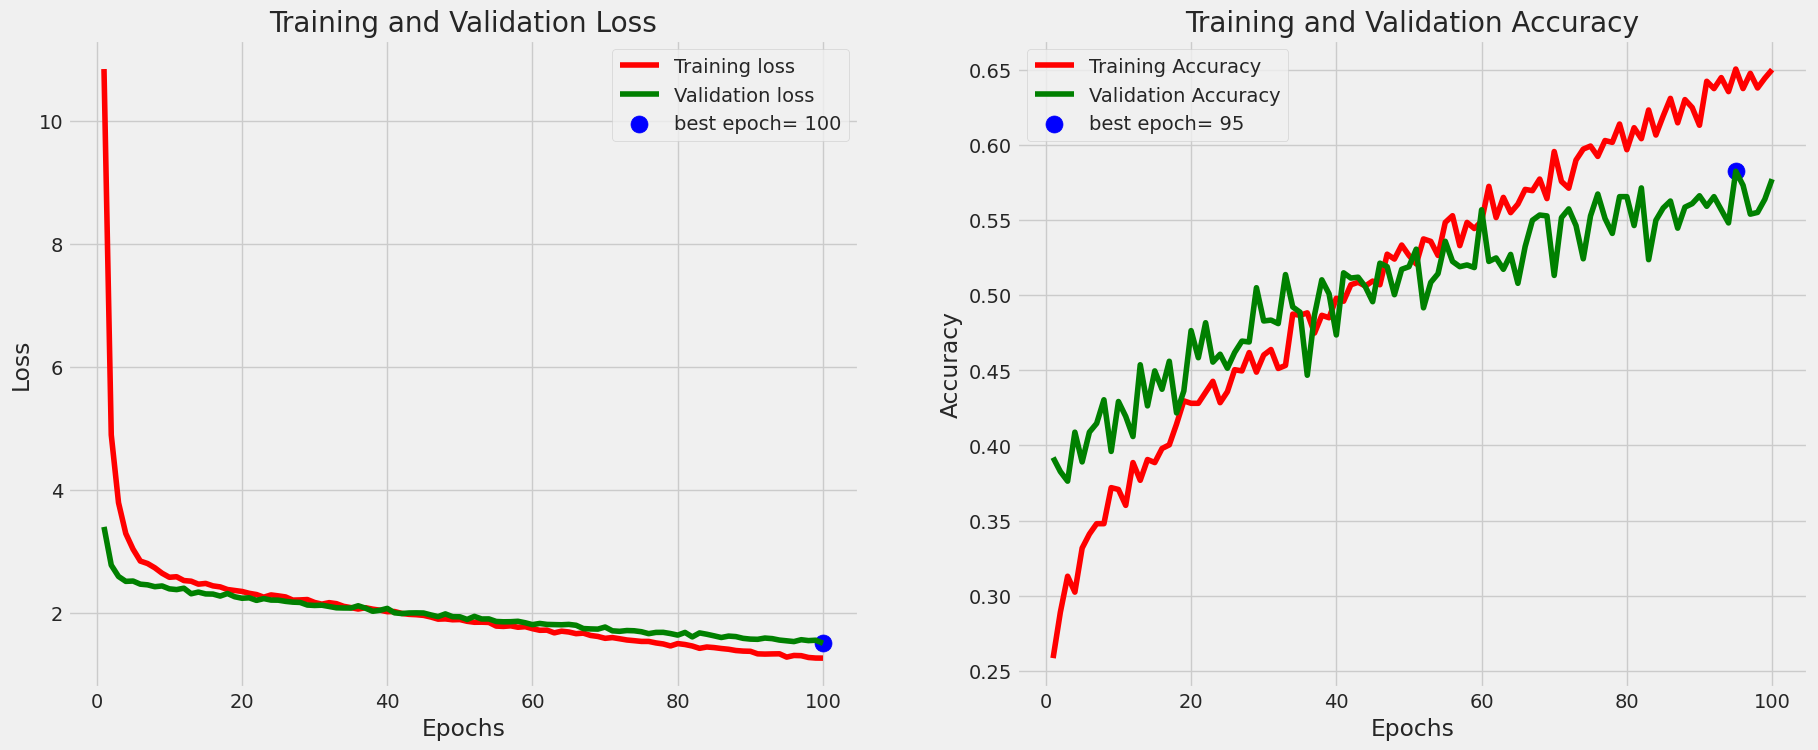

  7/859 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.8396 - loss: 0.9084

W0000 00:00:1747548704.322317     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


859/859 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.6502 - loss: 1.1963
accuracy on the test set is 64.49 %

model was saved as ./InceptionV3-ulcers-64.49.h5

class csv file was saved as ./class_dict.csv



In [77]:
tr_plot(history,0)
subject='ulcers'
acc=model.evaluate( test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg=f'accuracy on the test set is {acc:5.2f} %'
print_in_color(msg, (0,255,0),(55,65,80))
generator=train_gen
scale = 1
model_save_loc, csv_save_loc=saver(working_dir, model, model_name, subject, acc, img_size, scale,  generator)

 10/859 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step

W0000 00:00:1747548731.119145     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


859/859 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step


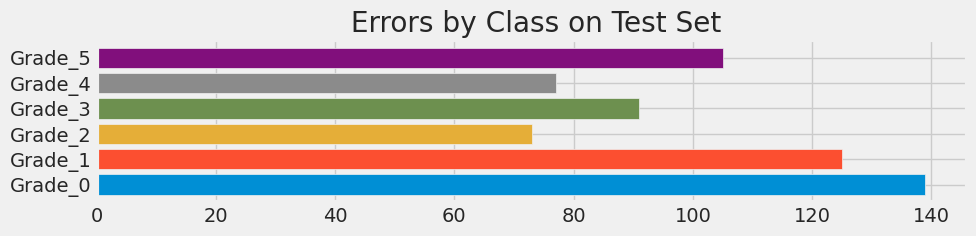

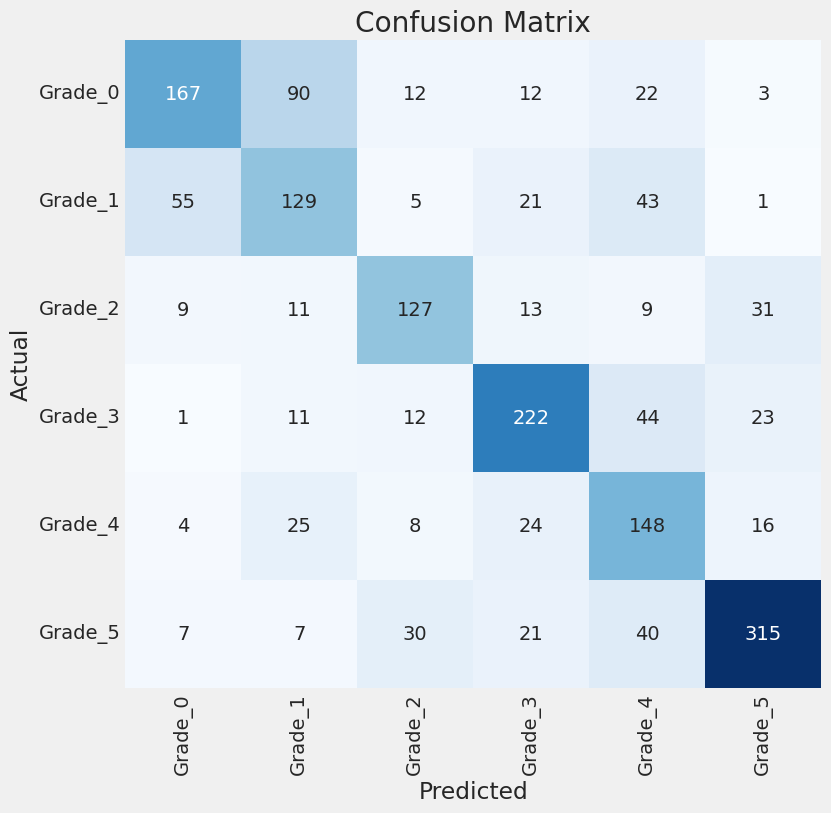

Classification Report:
----------------------
               precision    recall  f1-score   support

     Grade_0       0.69      0.55      0.61       306
     Grade_1       0.47      0.51      0.49       254
     Grade_2       0.65      0.64      0.64       200
     Grade_3       0.71      0.71      0.71       313
     Grade_4       0.48      0.66      0.56       225
     Grade_5       0.81      0.75      0.78       420

    accuracy                           0.64      1718
   macro avg       0.64      0.63      0.63      1718
weighted avg       0.66      0.64      0.65      1718



In [78]:
print_code=0
preds=model.predict(test_gen) 
print_info( test_gen, preds, print_code, working_dir, subject )  

In [85]:
import shutil
import cv2

# Set up the working directory and storage path
working_dir = '/kaggle/working'  # or adjust if different
store_path = os.path.join(working_dir, 'storage')

# Recreate the storage directory
if os.path.isdir(store_path):
    shutil.rmtree(store_path)
os.mkdir(store_path)

# Image path
img_path = '/kaggle/input/graded-dataset/graded_dataset/test/Grade_5/303549.png'

# Load the image
img = cv2.imread(img_path, cv2.IMREAD_REDUCED_COLOR_2)

# Check if image was loaded successfully
if img is None:
    raise FileNotFoundError(f"Failed to load image from: {img_path}")
    
# Convert to RGB (required by many models)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Save image to new storage path
file_name = os.path.split(img_path)[1]
dst_path = os.path.join(store_path, file_name)
cv2.imwrite(dst_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))  # Save in OpenCV format (BGR)



True

Saved files in storage path: ['303549.png']
📋 Class Mapping from CSV: ['Grade_0', 'Grade_1', 'Grade_2', 'Grade_3', 'Grade_4', 'Grade_5']
📦 Model is being loaded - this will take about 10 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step

🖼️ Image: 303549.png
🔢 Softmax Output: [0.001 0.    0.02  0.    0.001 0.978]
🎯 Predicted: Grade_5, Confidence: 97.82%


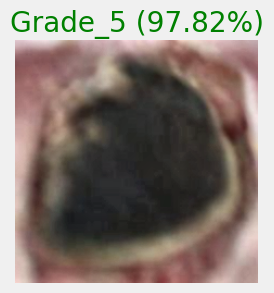

 image is of class Grade_5 with a probability of  97.82 %



In [86]:
# Confirm that file was saved
print("Saved files in storage path:", os.listdir(store_path))
csv_path=csv_save_loc # path to class_dict.csv
model_path=model_save_loc # path to the trained model
class_name, probability=predictor(store_path, csv_path,  model_path, crop_image = False) # run the classifier
msg=f' image is of class {class_name} with a probability of {probability * 100: 6.2f} %'
print_in_color(msg, (0,255,255), (65,85,55))

# DenseNet 121

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import DenseNet121

# Model definition
model_name = 'DenseNet121'
base_model = DenseNet121(
    include_top=False, 
    weights="imagenet",
    input_shape=img_shape,
    pooling=None
)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = Dropout(0.3)(x)
output = Dense(class_count, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Training setup
epochs = 100
patience = 10
stop_patience = 20
factor = 0.5
dwell = True

# Create and use the LRA callback
callbacks = [
    LRA(patience=patience, stop_patience=stop_patience, factor=factor, dwell=dwell),
    tf.keras.callbacks.EarlyStopping(patience=stop_patience, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=factor, patience=patience)
]

# Start training
history = model.fit(
    train_gen,
    epochs=epochs,
    validation_data=valid_gen,
    callbacks=callbacks,
    verbose=1
)

# Fine-tuning
print("Fine-tuning the model...")
for layer in base_model.layers[-30:]:  # Adjust as needed
    layer.trainable = True

model.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_fine = model.fit(
    train_gen,
    epochs=50,
    validation_data=valid_gen,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/100
 2/82 ━━━━━━━━━━━━━━━━━━━━ 8s 111ms/step - accuracy: 0.1250 - loss: 7.5619 

W0000 00:00:1747468340.574124     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.2077 - loss: 4.6158

W0000 00:00:1747468358.887356     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


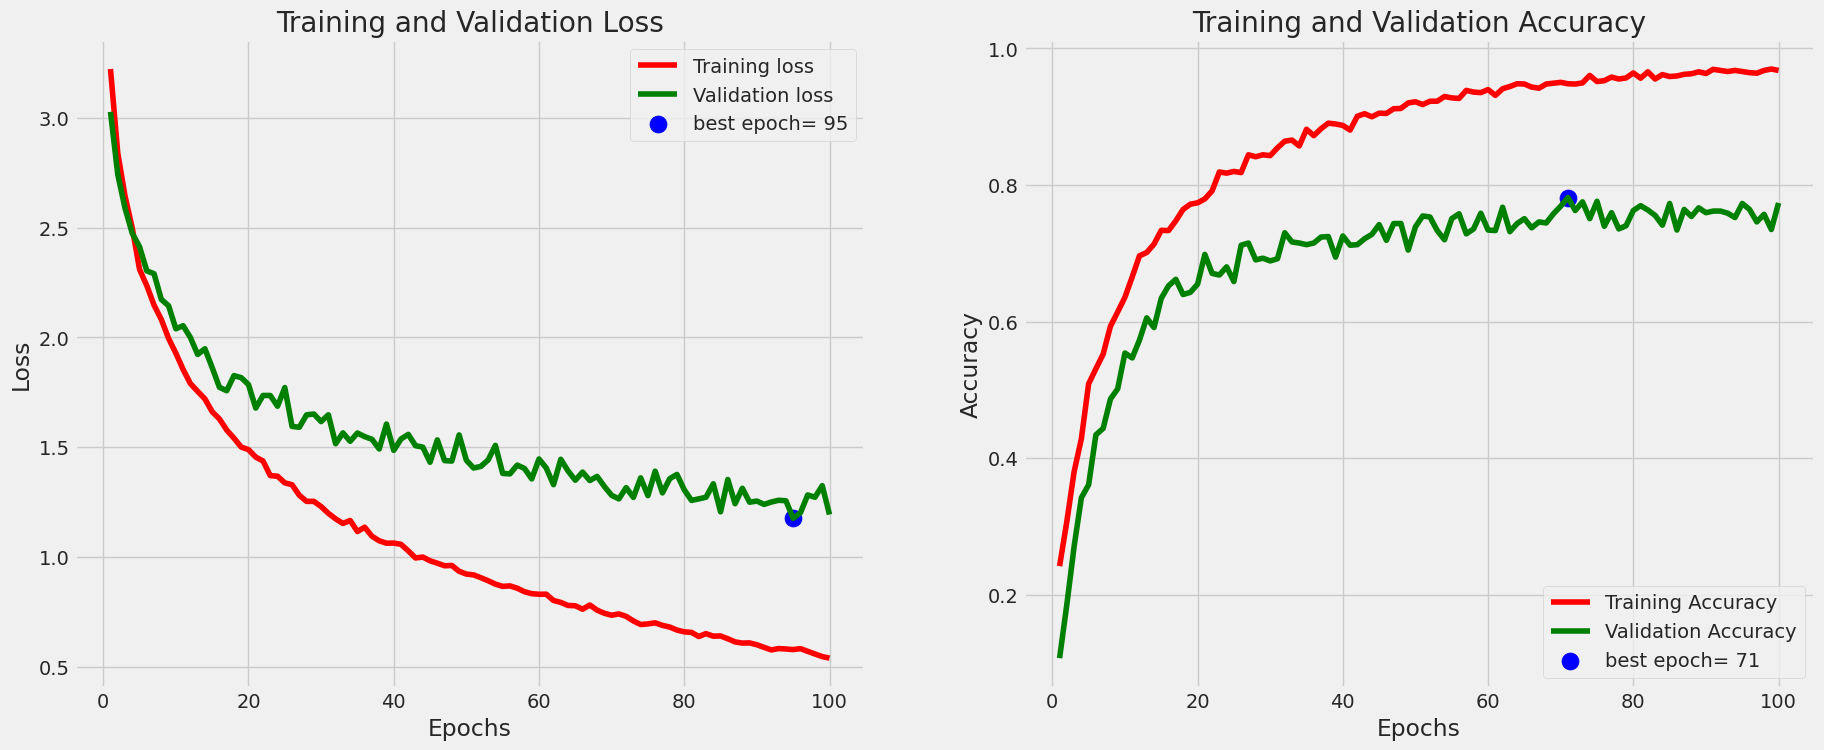

 4/97 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.7308 - loss: 0.8774

W0000 00:00:1747455873.699180     216 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


97/97 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7193 - loss: 1.1275


In [83]:
tr_plot(history,0)
subject='ulcers'
acc=model.evaluate( test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg=f'accuracy on the test set is {acc:5.2f} %'
print_in_color(msg, (0,255,0),(55,65,80))
generator=train_gen
scale = 1
model_save_loc, csv_save_loc=saver(working_dir, model, model_name, subject, acc, img_size, scale,  generator)

 5/97 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step

W0000 00:00:1747455889.268124     215 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


97/97 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step


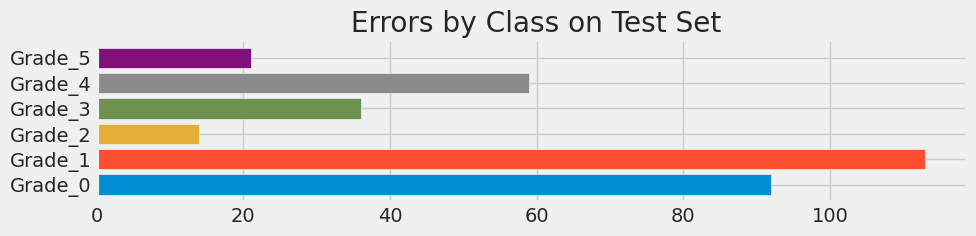

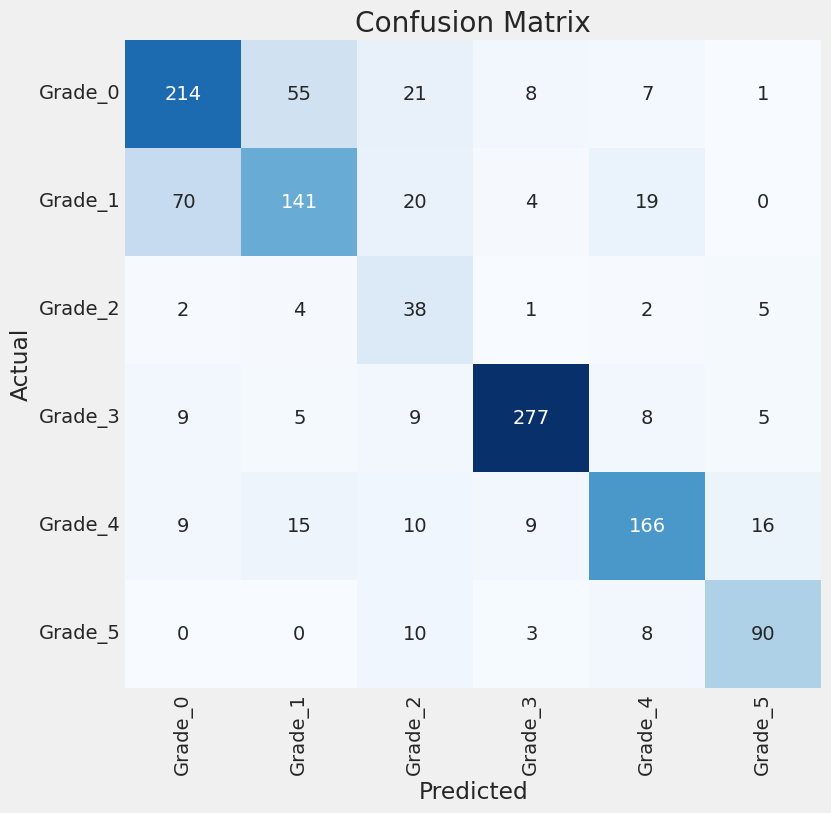

Classification Report:
----------------------
               precision    recall  f1-score   support

     Grade_0       0.70      0.70      0.70       306
     Grade_1       0.64      0.56      0.59       254
     Grade_2       0.35      0.73      0.48        52
     Grade_3       0.92      0.88      0.90       313
     Grade_4       0.79      0.74      0.76       225
     Grade_5       0.77      0.81      0.79       111

    accuracy                           0.73      1261
   macro avg       0.70      0.74      0.70      1261
weighted avg       0.75      0.73      0.74      1261



In [84]:
print_code=0
preds=model.predict(test_gen) 
print_info( test_gen, preds, print_code, working_dir, subject )  

✅ Randomly selected files in storage path:
• 301511.png
• 301769.png
• 303038.png
• 305024.png
• 306108.png
• 306301.png
• 306540.png
• 306553.png
• 306672.png
📋 Class Mapping from CSV: ['Grade_0', 'Grade_1', 'Grade_2', 'Grade_3', 'Grade_4', 'Grade_5']
📦 Model is being loaded - this will take about 10 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step

🖼️ Image: 306553.png
🔢 Softmax Output: [0.526 0.    0.324 0.149 0.    0.   ]
🎯 Predicted: Grade_0, Confidence: 52.63%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

🖼️ Image: 306540.png
🔢 Softmax Output: [0.078 0.001 0.341 0.112 0.003 0.465]
🎯 Predicted: Grade_5, Confidence: 46.51%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

🖼️ Image: 306108.png
🔢 Softmax Output: [0.952 0.    0.005 0.043 0.    0.   ]
🎯 Predicted: Grade_0, Confidence: 95.21%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

🖼️ Image: 303038.png
🔢 Softmax Output: [0.503 0.    0.333 0.162 0.    0.001]
🎯 Predicted: Grade_0, Confidence: 50.34%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step

🖼️ Image: 301769.png
🔢

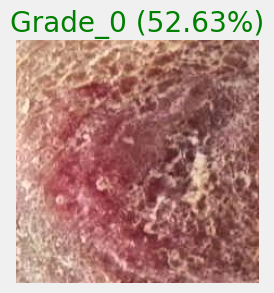

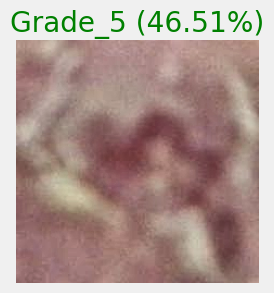

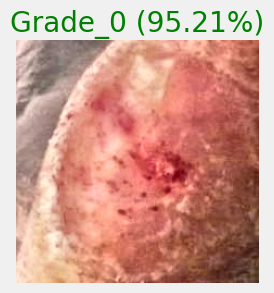

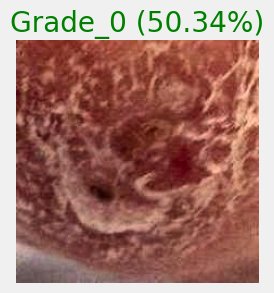

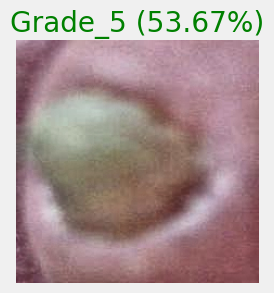

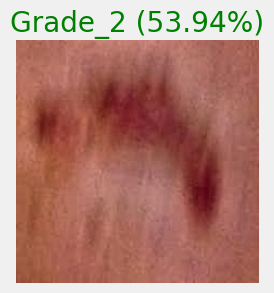

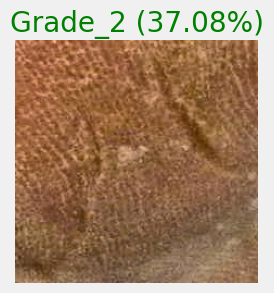

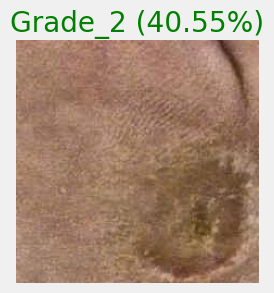

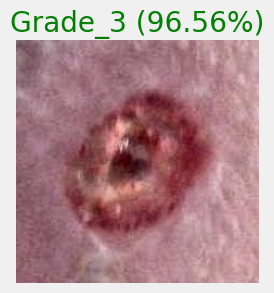

In [85]:
import os
import shutil
import cv2
import random

# === Setup Paths ===
working_dir = '/kaggle/working'
store_path = os.path.join(working_dir, 'storage')
img_dir = '/kaggle/input/grade-dataset/graded_dataset/test/Grade_0'

# === Recreate storage folder ===
if os.path.isdir(store_path):
    shutil.rmtree(store_path)
os.mkdir(store_path)

# === Get 9 random image files ===
all_imgs = random.sample(os.listdir(img_dir), 9)

# === Copy and convert images to storage path ===
for file_name in all_imgs:
    img_path = os.path.join(img_dir, file_name)
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)

    if img is None:
        print(f"❌ Failed to load: {img_path}")
        continue

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    save_path = os.path.join(store_path, file_name)
    cv2.imwrite(save_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

print("✅ Randomly selected files in storage path:")
for f in sorted(os.listdir(store_path)):
    print("•", f)

# === Define your CSV and model paths ===
csv_path = csv_save_loc   # e.g., '/kaggle/input/model/class_dict.csv'
model_path = model_save_loc  # e.g., '/kaggle/input/model/my_model.h5'

# === Run predictor on all 9 images together ===
class_name, probability = predictor(store_path, csv_path, model_path, crop_image=False)

# === Display final result ===
def print_in_color(text, fg, bg):
    from IPython.display import HTML, display
    style = f"color:rgb{fg}; background-color:rgb{bg}; padding:5px; font-size:16px; border-radius:5px;"
    display(HTML(f"<div style='{style}'>{text}</div>"))

msg = f'🧠 Final predicted class (voting across 9 images): <b>{class_name}</b><br>🔢 Confidence: <b>{probability * 100:.2f}%</b>'
print_in_color(msg, (0, 255, 255), (65, 85, 55))


# Mobile Netv3

In [93]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV3Large

# Model definition
model_name = 'MobileNetV3-Large'
base_model = MobileNetV3Large(
    include_top=False, 
    weights="imagenet",
    input_shape=img_shape,  # e.g., (224, 224, 3)
    pooling=None
)

# Freeze base layers
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = Dropout(0.3)(x)
output = Dense(class_count, activation='softmax')(x)  # class_count = number of output classes

model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Training setup
epochs = 100
patience = 10
stop_patience = 20
factor = 0.5
dwell = True

# Callbacks
callbacks = [
    LRA(patience=patience, stop_patience=stop_patience, factor=factor, dwell=dwell),
    tf.keras.callbacks.EarlyStopping(patience=stop_patience, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=factor, patience=patience)
]

# Train model
history = model.fit(
    train_gen,
    epochs=epochs,
    validation_data=valid_gen,
    callbacks=callbacks,
    verbose=1
)


# === Fine-tuning ===
print("Fine-tuning the model...")
for layer in base_model.layers[-30:]:  # You can increase this for deeper tuning
    layer.trainable = True

model.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_fine = model.fit(
    train_gen,
    epochs=50,
    validation_data=valid_gen,
    callbacks=callbacks,
    verbose=1
)

12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/100
 3/82 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 0.1185 - loss: 3.3836  

W0000 00:00:1747550113.736043     128 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.2375 - loss: 2.9076

W0000 00:00:1747550128.119373     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1747550140.299768     128 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


82/82 ━━━━━━━━━━━━━━━━━━━━ 46s 331ms/step - accuracy: 0.2393 - loss: 2.9026 - val_accuracy: 0.5504 - val_loss: 2.2316 - learning_rate: 1.0000e-04
Epoch 2/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 20s 233ms/step - accuracy: 0.4448 - loss: 2.3419 - val_accuracy: 0.6010 - val_loss: 2.0241 - learning_rate: 1.0000e-04
Epoch 3/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 14s 164ms/step - accuracy: 0.5504 - loss: 2.0867 - val_accuracy: 0.6453 - val_loss: 1.8899 - learning_rate: 1.0000e-04
Epoch 4/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 21s 251ms/step - accuracy: 0.5853 - loss: 1.9760 - val_accuracy: 0.6628 - val_loss: 1.8213 - learning_rate: 1.0000e-04
Epoch 5/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 14s 162ms/step - accuracy: 0.6621 - loss: 1.8389 - val_accuracy: 0.6826 - val_loss: 1.7418 - learning_rate: 1.0000e-04
Epoch 6/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 14s 165ms/step - accuracy: 0.7082 - loss: 1.7301 - val_accuracy: 0.7204 - val_loss: 1.6704 - learning_rate: 1.0000e-04
Epoch 7/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 14s 165ms/step - accuracy

W0000 00:00:1747552341.664274     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.7595 - loss: 1.0039

W0000 00:00:1747552358.543653     130 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


82/82 ━━━━━━━━━━━━━━━━━━━━ 49s 337ms/step - accuracy: 0.7599 - loss: 1.0026 - val_accuracy: 0.8160 - val_loss: 0.9752 - learning_rate: 1.0000e-05
Epoch 2/50


W0000 00:00:1747552368.825808     130 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


82/82 ━━━━━━━━━━━━━━━━━━━━ 24s 280ms/step - accuracy: 0.8252 - loss: 0.8068 - val_accuracy: 0.8125 - val_loss: 0.9760 - learning_rate: 1.0000e-05
Epoch 3/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 23s 264ms/step - accuracy: 0.8557 - loss: 0.6727 - val_accuracy: 0.8171 - val_loss: 0.9692 - learning_rate: 1.0000e-05
Epoch 4/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 22s 257ms/step - accuracy: 0.8672 - loss: 0.6304 - val_accuracy: 0.8136 - val_loss: 0.9699 - learning_rate: 1.0000e-05
Epoch 5/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 23s 267ms/step - accuracy: 0.8968 - loss: 0.5819 - val_accuracy: 0.8136 - val_loss: 0.9665 - learning_rate: 1.0000e-05
Epoch 6/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 23s 261ms/step - accuracy: 0.9012 - loss: 0.5454 - val_accuracy: 0.8119 - val_loss: 0.9651 - learning_rate: 1.0000e-05
Epoch 7/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 23s 267ms/step - accuracy: 0.9167 - loss: 0.5227 - val_accuracy: 0.8037 - val_loss: 0.9702 - learning_rate: 1.0000e-05
Epoch 8/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 22s 261ms/step - accuracy: 0.92

AttributeError: 'Adam' object has no attribute 'lr'

In [97]:
# === Fine-tuning ===
print("Fine-tuning the model...")
for layer in base_model.layers[-30:]:  # You can increase this for deeper tuning
    layer.trainable = True

model.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_fine = model.fit(
    train_gen,
    epochs=10,
    validation_data=valid_gen,
    callbacks=callbacks,
    verbose=1
)

Fine-tuning the model...
Epoch 1/10
 1/82 ━━━━━━━━━━━━━━━━━━━━ 25:56 19s/step - accuracy: 1.0000 - loss: 0.2912

W0000 00:00:1747555840.979818     128 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9955 - loss: 0.2865

W0000 00:00:1747555855.446628     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


82/82 ━━━━━━━━━━━━━━━━━━━━ 43s 298ms/step - accuracy: 0.9955 - loss: 0.2865 - val_accuracy: 0.7932 - val_loss: 1.0827 - learning_rate: 1.0000e-05
Epoch 2/10


W0000 00:00:1747555864.960588     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


82/82 ━━━━━━━━━━━━━━━━━━━━ 15s 179ms/step - accuracy: 0.9960 - loss: 0.2784 - val_accuracy: 0.7962 - val_loss: 1.0813 - learning_rate: 1.0000e-05
Epoch 3/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 22s 266ms/step - accuracy: 0.9933 - loss: 0.2755 - val_accuracy: 0.7950 - val_loss: 1.0931 - learning_rate: 1.0000e-05
Epoch 4/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 14s 161ms/step - accuracy: 0.9939 - loss: 0.2815 - val_accuracy: 0.7897 - val_loss: 1.1186 - learning_rate: 1.0000e-05
Epoch 5/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 14s 162ms/step - accuracy: 0.9977 - loss: 0.2729 - val_accuracy: 0.7956 - val_loss: 1.0968 - learning_rate: 1.0000e-05
Epoch 6/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 14s 167ms/step - accuracy: 0.9962 - loss: 0.2747 - val_accuracy: 0.7950 - val_loss: 1.1056 - learning_rate: 1.0000e-05
Epoch 7/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 14s 162ms/step - accuracy: 0.9974 - loss: 0.2705 - val_accuracy: 0.7985 - val_loss: 1.0902 - learning_rate: 1.0000e-05
Epoch 8/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 14s 164ms/step - accuracy: 0.99

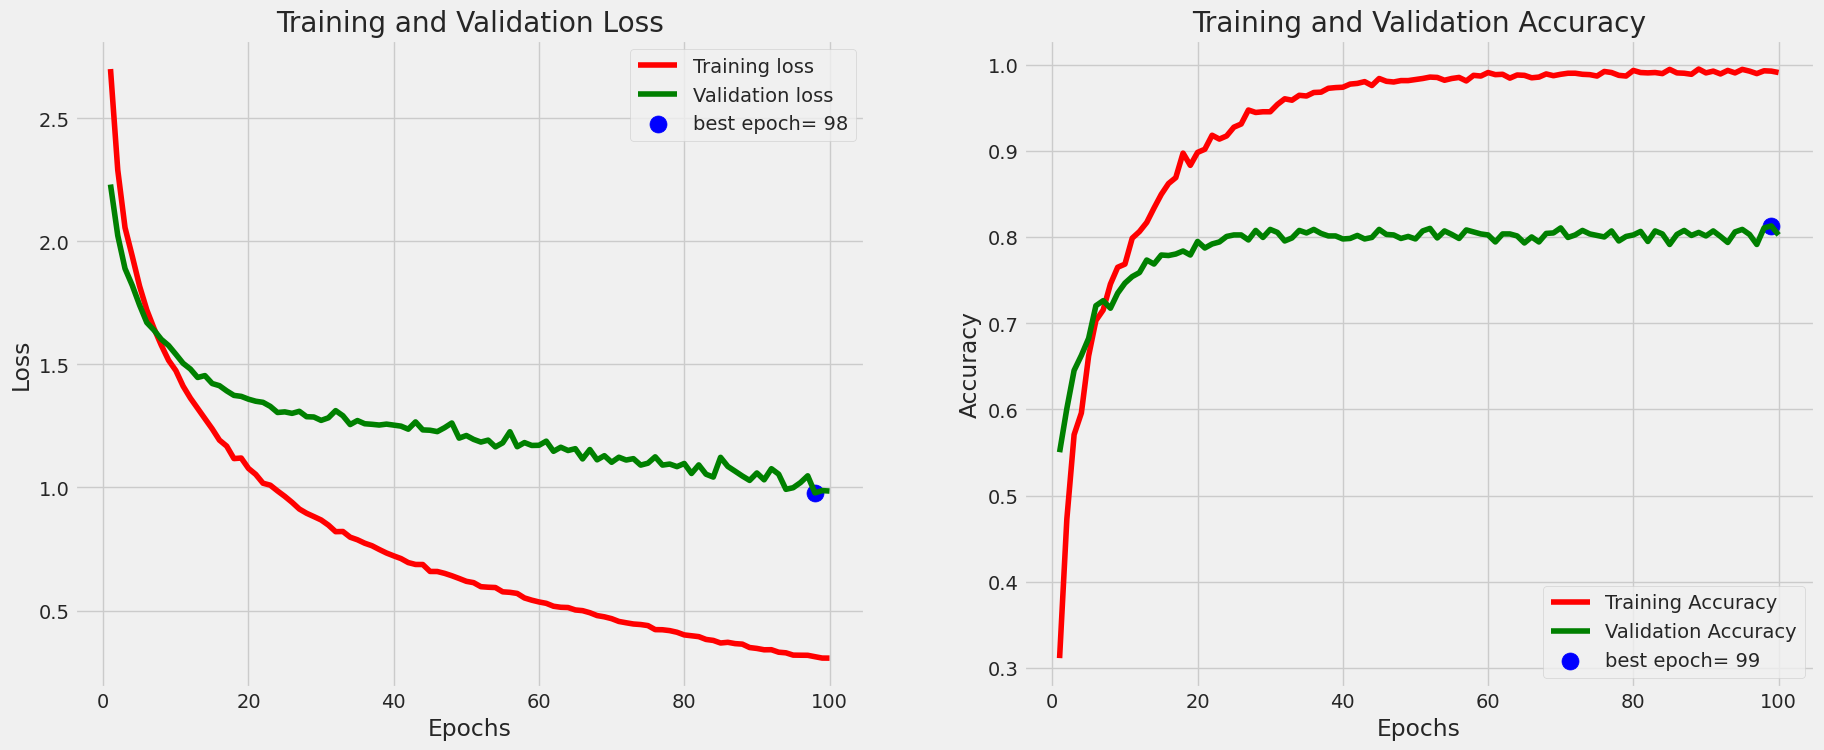

859/859 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7858 - loss: 1.0909
accuracy on the test set is 78.93 %

model was saved as ./MobileNetV3-Large-ulcers-78.92.keras

class csv file was saved as ./class_dict.csv



In [113]:
tr_plot(history,0)
subject='ulcers'
acc=model.evaluate( test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg=f'accuracy on the test set is {acc:5.2f} %'
print_in_color(msg, (0,255,0),(55,65,80))
generator=train_gen
scale = 1
model_save_loc, csv_save_loc=saver(working_dir, model, model_name, subject, acc, img_size, scale,  generator)

859/859 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step


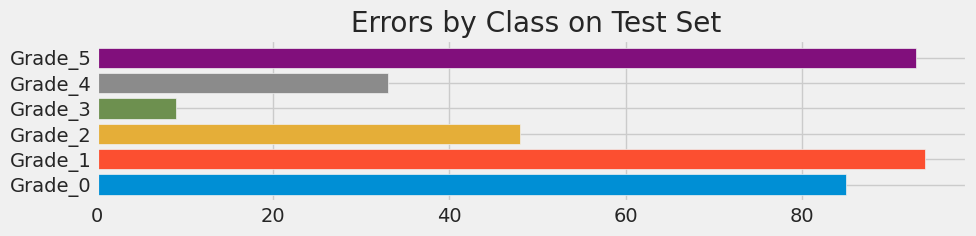

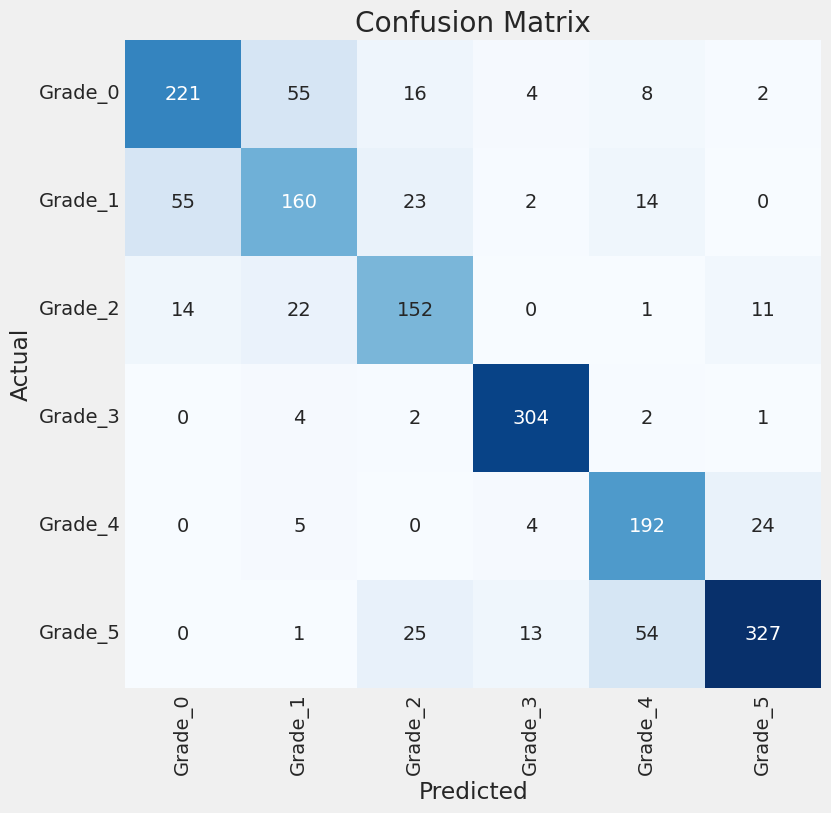

Classification Report:
----------------------
               precision    recall  f1-score   support

     Grade_0       0.76      0.72      0.74       306
     Grade_1       0.65      0.63      0.64       254
     Grade_2       0.70      0.76      0.73       200
     Grade_3       0.93      0.97      0.95       313
     Grade_4       0.71      0.85      0.77       225
     Grade_5       0.90      0.78      0.83       420

    accuracy                           0.79      1718
   macro avg       0.77      0.79      0.78      1718
weighted avg       0.79      0.79      0.79      1718



In [114]:
print_code=0
preds=model.predict(test_gen) 
print_info( test_gen, preds, print_code, working_dir, subject )  

In [119]:
import shutil
import cv2

# Set up the working directory and storage path
working_dir = '/kaggle/working'  # or adjust if different
store_path = os.path.join(working_dir, 'storage')

# Recreate the storage directory
if os.path.isdir(store_path):
    shutil.rmtree(store_path)
os.mkdir(store_path)

# Image path
img_path = '/kaggle/input/graded-dataset/graded_dataset/test/Grade_1/301027.png'

# Load the image
img = cv2.imread(img_path, cv2.IMREAD_REDUCED_COLOR_2)

# Check if image was loaded successfully
if img is None:
    raise FileNotFoundError(f"Failed to load image from: {img_path}")
    
# Convert to RGB (required by many models)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Save image to new storage path
file_name = os.path.split(img_path)[1]
dst_path = os.path.join(store_path, file_name)
cv2.imwrite(dst_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))  # Save in OpenCV format (BGR)



True

Saved files in storage path: ['301027.png']
📋 Class Mapping from CSV: ['Grade_0', 'Grade_1', 'Grade_2', 'Grade_3', 'Grade_4', 'Grade_5']
📦 Model is being loaded - this will take about 10 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step

🖼️ Image: 301027.png
🔢 Softmax Output: [0.001 0.    0.991 0.    0.    0.008]
🎯 Predicted: Grade_2, Confidence: 99.13%


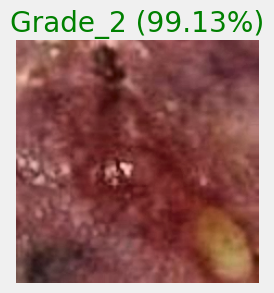

 image is of class Grade_2 with a probability of  99.13 %



In [120]:
# Confirm that file was saved
print("Saved files in storage path:", os.listdir(store_path))
csv_path=csv_save_loc # path to class_dict.csv
model_path=model_save_loc # path to the trained model
class_name, probability=predictor(store_path, csv_path,  model_path, crop_image = False) # run the classifier
msg=f' image is of class {class_name} with a probability of {probability * 100: 6.2f} %'
print_in_color(msg, (0,255,255), (65,85,55))

# Efficentnetv2L

In [46]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetV2L  # ✅ EfficientNetV2-L

# === Model Definition ===
model_name = 'EfficientNetV2-L'
base_model = EfficientNetV2L(
    include_top=False, 
    weights="imagenet",
    input_shape=img_shape,  # e.g., (480, 480, 3) recommended for V2-L
    pooling=None
)

# Freeze base model layers initially
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = Dropout(0.3)(x)
output = Dense(class_count, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# === Compile ===
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

epochs=50
patience = 3
stop_patience = 6
factor = 0.5
dwell = True

# === Callbacks ===
callbacks = [
    LRA(patience=patience, stop_patience=stop_patience, factor=factor, dwell=dwell),
    tf.keras.callbacks.EarlyStopping(patience=stop_patience, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=factor, patience=patience)
]

# === Initial Training ===
history = model.fit(
    train_gen,
    epochs=epochs,
    validation_data=valid_gen,
    callbacks=callbacks,
    verbose=1
)



Epoch 1/50
 1/82 ━━━━━━━━━━━━━━━━━━━━ 4:01:54 179s/step - accuracy: 0.1667 - loss: 2.9552

W0000 00:00:1747568491.556913     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.2601 - loss: 2.8105

W0000 00:00:1747568539.427895     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1747568567.500160     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


82/82 ━━━━━━━━━━━━━━━━━━━━ 257s 966ms/step - accuracy: 0.2609 - loss: 2.8095 - val_accuracy: 0.5108 - val_loss: 2.5108 - learning_rate: 1.0000e-04
Epoch 2/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 50s 599ms/step - accuracy: 0.4619 - loss: 2.4976 - val_accuracy: 0.5591 - val_loss: 2.2729 - learning_rate: 1.0000e-04
Epoch 3/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 46s 561ms/step - accuracy: 0.5293 - loss: 2.2692 - val_accuracy: 0.5830 - val_loss: 2.1405 - learning_rate: 1.0000e-04
Epoch 4/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 48s 579ms/step - accuracy: 0.5716 - loss: 2.1418 - val_accuracy: 0.6010 - val_loss: 2.0383 - learning_rate: 1.0000e-04
Epoch 5/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 47s 567ms/step - accuracy: 0.6063 - loss: 2.0303 - val_accuracy: 0.6179 - val_loss: 1.9751 - learning_rate: 1.0000e-04
Epoch 6/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 48s 576ms/step - accuracy: 0.6296 - loss: 1.9658 - val_accuracy: 0.6342 - val_loss: 1.9238 - learning_rate: 1.0000e-04
Epoch 7/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 48s 573ms/step - accuracy: 0.6

In [47]:
# === Fine-tuning ===
print("Fine-tuning the model...")
for layer in base_model.layers[-100:]:  # ✅ deeper fine-tuning than -30
    layer.trainable = True

model.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_fine = model.fit(
    train_gen,
    epochs=50,
    validation_data=valid_gen,
    callbacks=callbacks,
    verbose=1
)


Fine-tuning the model...
Epoch 1/50


W0000 00:00:1747571107.337016     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - accuracy: 0.8014 - loss: 1.1667

W0000 00:00:1747571165.498784     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1747571192.987822     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


82/82 ━━━━━━━━━━━━━━━━━━━━ 298s 1s/step - accuracy: 0.8016 - loss: 1.1664 - val_accuracy: 0.7676 - val_loss: 1.2918 - learning_rate: 1.0000e-05
Epoch 2/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 58s 700ms/step - accuracy: 0.8725 - loss: 0.9792 - val_accuracy: 0.7851 - val_loss: 1.2499 - learning_rate: 1.0000e-05
Epoch 3/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 56s 672ms/step - accuracy: 0.9046 - loss: 0.9027 - val_accuracy: 0.7962 - val_loss: 1.2259 - learning_rate: 1.0000e-05
Epoch 4/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 56s 679ms/step - accuracy: 0.9383 - loss: 0.8319 - val_accuracy: 0.8031 - val_loss: 1.2035 - learning_rate: 1.0000e-05
Epoch 5/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 56s 673ms/step - accuracy: 0.9396 - loss: 0.8154 - val_accuracy: 0.8049 - val_loss: 1.2207 - learning_rate: 1.0000e-05
Epoch 6/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 56s 671ms/step - accuracy: 0.9436 - loss: 0.8022 - val_accuracy: 0.8090 - val_loss: 1.2073 - learning_rate: 1.0000e-05


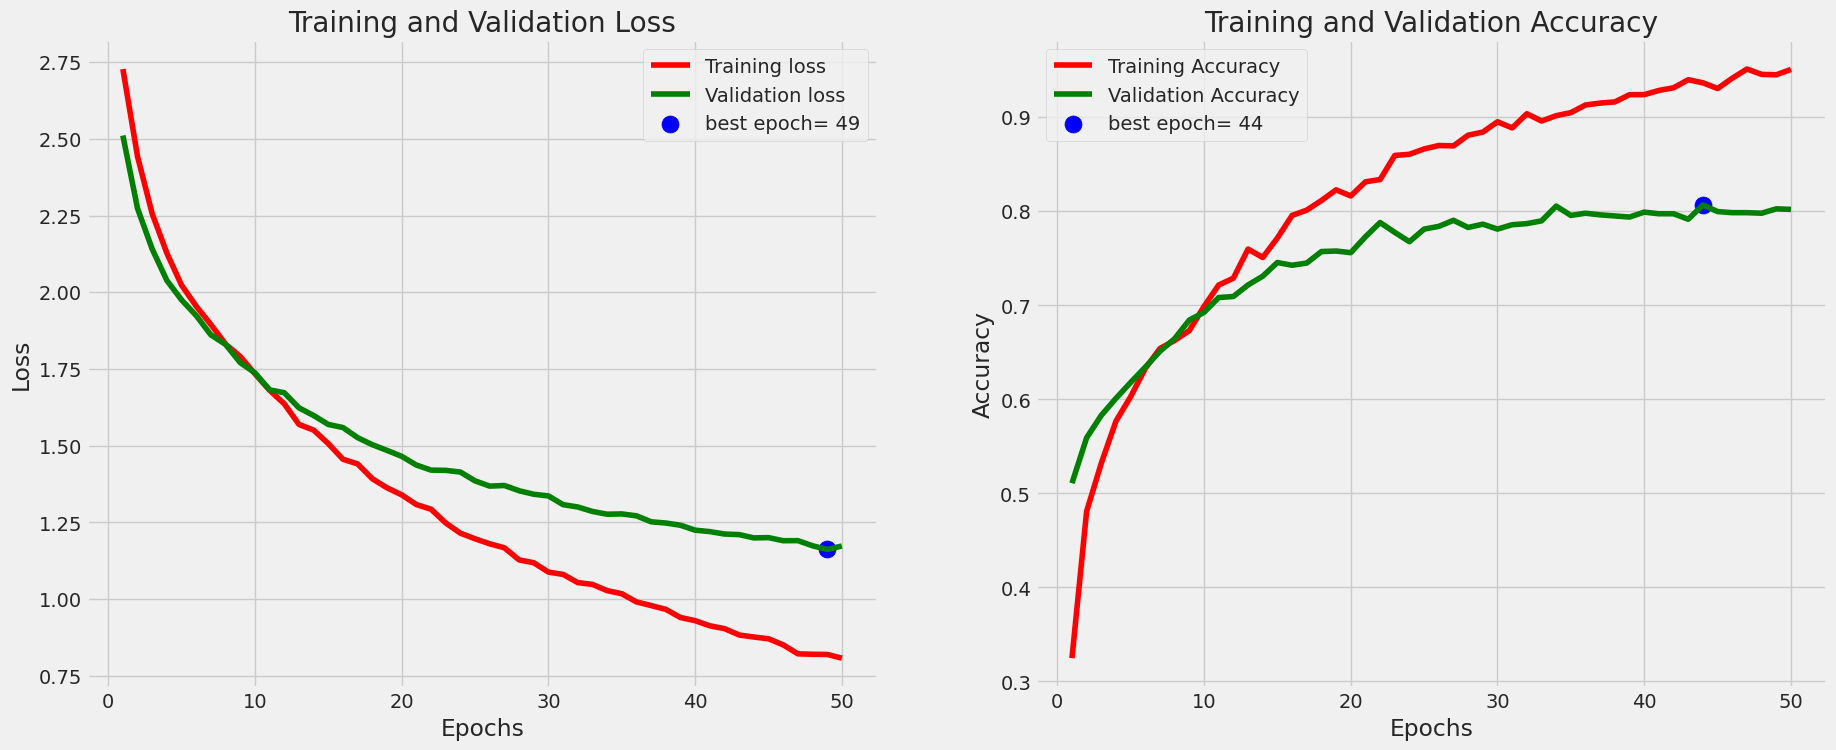

  3/859 ━━━━━━━━━━━━━━━━━━━━ 1:00 70ms/step - accuracy: 1.0000 - loss: 0.7338 

W0000 00:00:1747571492.772346     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


859/859 ━━━━━━━━━━━━━━━━━━━━ 51s 41ms/step - accuracy: 0.7635 - loss: 1.3450
accuracy on the test set is 76.08 %

model was saved as ./EfficientNetV2-L-ulcers-76.07.keras

class csv file was saved as ./class_dict.csv



In [48]:
tr_plot(history,0)
subject='ulcers'
acc=model.evaluate( test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg=f'accuracy on the test set is {acc:5.2f} %'
print_in_color(msg, (0,255,0),(55,65,80))
generator=train_gen
scale = 1
model_save_loc, csv_save_loc=saver(working_dir, model, model_name, subject, acc, img_size, scale,  generator)

  5/859 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step 

W0000 00:00:1747571553.733927     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


859/859 ━━━━━━━━━━━━━━━━━━━━ 51s 35ms/step


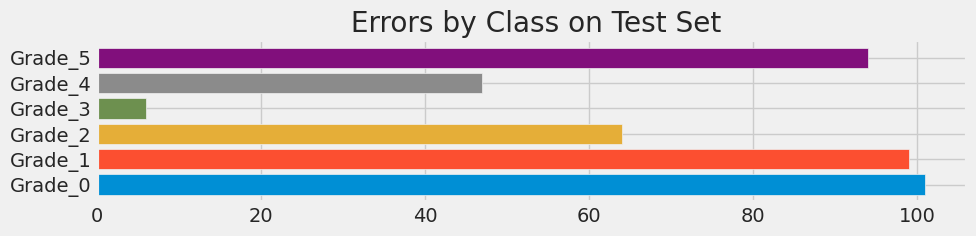

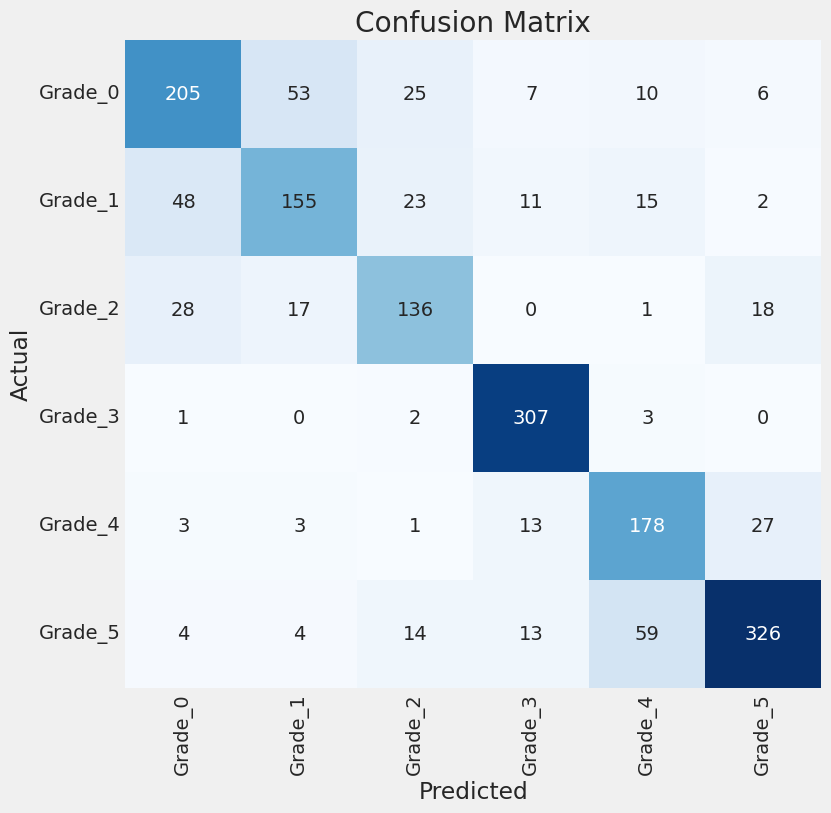

Classification Report:
----------------------
               precision    recall  f1-score   support

     Grade_0       0.71      0.67      0.69       306
     Grade_1       0.67      0.61      0.64       254
     Grade_2       0.68      0.68      0.68       200
     Grade_3       0.87      0.98      0.92       313
     Grade_4       0.67      0.79      0.73       225
     Grade_5       0.86      0.78      0.82       420

    accuracy                           0.76      1718
   macro avg       0.74      0.75      0.75      1718
weighted avg       0.76      0.76      0.76      1718



In [49]:
print_code=0
preds=model.predict(test_gen) 
print_info( test_gen, preds, print_code, working_dir, subject )  

In [58]:
import os
import cv2

# === Define storage path ===
store_path = '/kaggle/working/storage'  # change if needed

# Recreate directory if needed
if not os.path.exists(store_path):
    os.makedirs(store_path)

# === Define image paths ===
image_paths = [
    '/kaggle/input/graded-dataset/graded_dataset/test/Grade_2/301692.png',
    '/kaggle/input/graded-dataset/graded_dataset/test/Grade_3/301075.png',
    '/kaggle/input/graded-dataset/graded_dataset/test/Grade_4/301047.png',
    '/kaggle/input/graded-dataset/graded_dataset/test/Grade_5/301167.png',
    '/kaggle/input/graded-dataset/graded_dataset/test/Grade_5/302906.png',
    '/kaggle/input/graded-dataset/graded_dataset/test/Grade_0/301095.png',
    '/kaggle/input/graded-dataset/graded_dataset/test/Grade_3/301724.png'
]

# === Process and save each image ===
for path in image_paths:
    img = cv2.imread(path, cv2.IMREAD_REDUCED_COLOR_2)
    if img is None:
        raise FileNotFoundError(f"❌ Failed to load: {path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    save_name = os.path.basename(path)
    save_path = os.path.join(store_path, save_name)
    cv2.imwrite(save_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

# === Confirm Saved Files ===
print("✅ Saved files in storage path:")
print(os.listdir(store_path))


✅ Saved files in storage path:
['301095.png', '301692.png', '301047.png', '301167.png', '302906.png', '301075.png', '301724.png']


📋 Class Mapping from CSV: ['Grade_0', 'Grade_1', 'Grade_2', 'Grade_3', 'Grade_4', 'Grade_5']
📦 Model is being loaded - this will take about 10 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step

🖼️ Image: 301692.png
🔢 Softmax Output: [0.253 0.08  0.127 0.101 0.055 0.385]
🎯 Predicted: Grade_5, Confidence: 38.45%


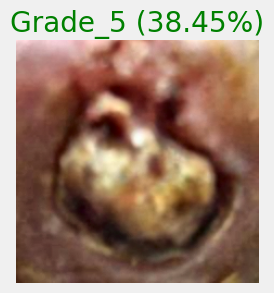

📋 Class Mapping from CSV: ['Grade_0', 'Grade_1', 'Grade_2', 'Grade_3', 'Grade_4', 'Grade_5']
📦 Model is being loaded - this will take about 10 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step

🖼️ Image: 301075.png
🔢 Softmax Output: [0.287 0.087 0.163 0.067 0.053 0.343]
🎯 Predicted: Grade_5, Confidence: 34.25%


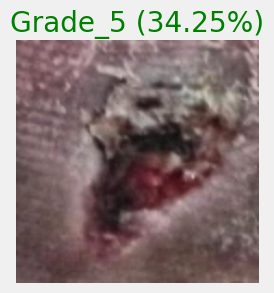

📋 Class Mapping from CSV: ['Grade_0', 'Grade_1', 'Grade_2', 'Grade_3', 'Grade_4', 'Grade_5']
📦 Model is being loaded - this will take about 10 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step

🖼️ Image: 301047.png
🔢 Softmax Output: [0.2   0.071 0.138 0.077 0.047 0.465]
🎯 Predicted: Grade_5, Confidence: 46.54%


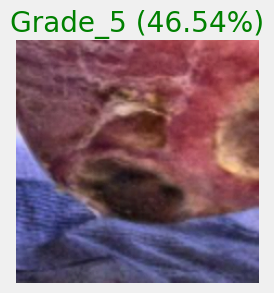

📋 Class Mapping from CSV: ['Grade_0', 'Grade_1', 'Grade_2', 'Grade_3', 'Grade_4', 'Grade_5']
📦 Model is being loaded - this will take about 10 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step

🖼️ Image: 301167.png
🔢 Softmax Output: [0.211 0.08  0.136 0.071 0.055 0.447]
🎯 Predicted: Grade_5, Confidence: 44.67%


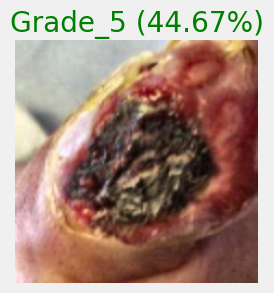

📋 Class Mapping from CSV: ['Grade_0', 'Grade_1', 'Grade_2', 'Grade_3', 'Grade_4', 'Grade_5']
📦 Model is being loaded - this will take about 10 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step

🖼️ Image: 302906.png
🔢 Softmax Output: [0.177 0.071 0.099 0.102 0.056 0.495]
🎯 Predicted: Grade_5, Confidence: 49.52%


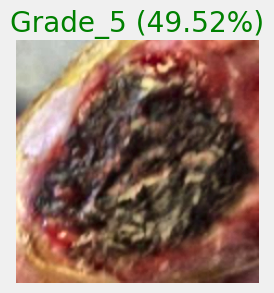

📋 Class Mapping from CSV: ['Grade_0', 'Grade_1', 'Grade_2', 'Grade_3', 'Grade_4', 'Grade_5']
📦 Model is being loaded - this will take about 10 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step

🖼️ Image: 301095.png
🔢 Softmax Output: [0.21  0.069 0.191 0.07  0.046 0.415]
🎯 Predicted: Grade_5, Confidence: 41.48%


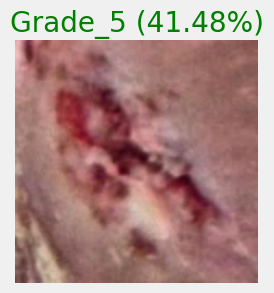

📋 Class Mapping from CSV: ['Grade_0', 'Grade_1', 'Grade_2', 'Grade_3', 'Grade_4', 'Grade_5']
📦 Model is being loaded - this will take about 10 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step

🖼️ Image: 301724.png
🔢 Softmax Output: [0.199 0.075 0.15  0.073 0.049 0.454]
🎯 Predicted: Grade_5, Confidence: 45.45%


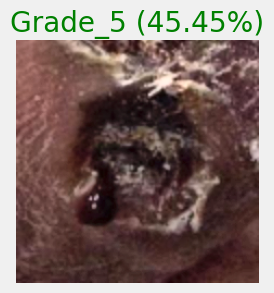

In [59]:
base_dir = '/kaggle/working/storage'

# === Image 3 ===
class_name, probability = predictor(f"{base_dir}/301692.png", csv_path, model_path, crop_image=False)
msg = f'Image 3 ➜ class: {class_name} | confidence: {probability * 100:6.2f} %'
print_in_color(msg, (0, 255, 255), (65, 85, 55))

# === Image 4 ===
class_name, probability = predictor(f"{base_dir}/301075.png", csv_path, model_path, crop_image=False)
msg = f'Image 4 ➜ class: {class_name} | confidence: {probability * 100:6.2f} %'
print_in_color(msg, (0, 255, 255), (65, 85, 55))

# === Image 5 ===
class_name, probability = predictor(f"{base_dir}/301047.png", csv_path, model_path, crop_image=False)
msg = f'Image 5 ➜ class: {class_name} | confidence: {probability * 100:6.2f} %'
print_in_color(msg, (0, 255, 255), (65, 85, 55))

# === Image 6 ===
class_name, probability = predictor(f"{base_dir}/301167.png", csv_path, model_path, crop_image=False)
msg = f'Image 6 ➜ class: {class_name} | confidence: {probability * 100:6.2f} %'
print_in_color(msg, (0, 255, 255), (65, 85, 55))

# === Image 7 ===
class_name, probability = predictor(f"{base_dir}/302906.png", csv_path, model_path, crop_image=False)
msg = f'Image 7 ➜ class: {class_name} | confidence: {probability * 100:6.2f} %'
print_in_color(msg, (0, 255, 255), (65, 85, 55))

# === Image 8 ===
class_name, probability = predictor(f"{base_dir}/301095.png", csv_path, model_path, crop_image=False)
msg = f'Image 8 ➜ class: {class_name} | confidence: {probability * 100:6.2f} %'
print_in_color(msg, (0, 255, 255), (65, 85, 55))

# === Image 9 ===
class_name, probability = predictor(f"{base_dir}/301724.png", csv_path, model_path, crop_image=False)
msg = f'Image 9 ➜ class: {class_name} | confidence: {probability * 100:6.2f} %'
print_in_color(msg, (0, 255, 255), (65, 85, 55))
